In [4]:

import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister,ClassicalRegister, Aer, transpile,IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
import pylatexenc
# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

import pyzx as zx
import matplotlib.pyplot as plt

In [5]:
!pip install pylatexenc
!pip install pillow

# 2 addressing qubit QRAM 

## Read Operation

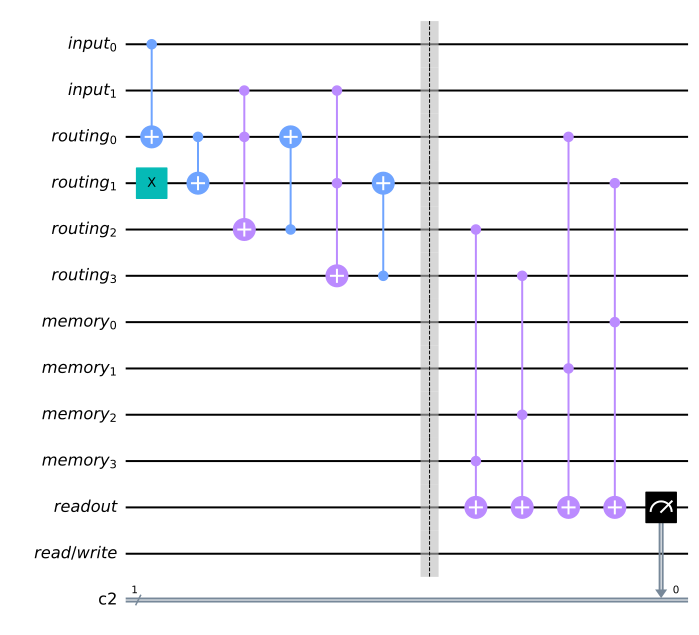

In [8]:
inp = QuantumRegister(2,'input')
r = QuantumRegister(4,'routing')
mem = QuantumRegister(4,'memory')
rdwr = QuantumRegister(1,'read/write')
ro = QuantumRegister(1,'readout')
cr = ClassicalRegister(1)
qcr = QuantumCircuit(inp,r,mem,ro,rdwr,cr)
#qcr.x(inp[0])
#qcr.x(inp[1])
#qc.i(mem[1:4])
'''
qc.cswap(inp[0],mem[0],mem[2])
qc.cswap(inp[1],mem[0],mem[1])
qc.cswap(inp[1],mem[2],mem[3])
'''
### Routing nodes ####

qcr.cx(inp[0],r[0])
qcr.x(r[1])
qcr.cx(r[0],r[1])

qcr.ccx(inp[1],r[0],r[2])
qcr.cx(r[2],r[0])

qcr.ccx(inp[1],r[1],r[3])
qcr.cx(r[3],r[1])

qcr.barrier()

### Read State ###
qcr.ccx(r[2],mem[3],ro[0])
qcr.ccx(r[3],mem[2],ro[0])
qcr.ccx(r[0],mem[1],ro[0])
qcr.ccx(r[1],mem[0],ro[0])
qcr.measure(ro,cr)

qcr.draw('mpl')

## Write Operation

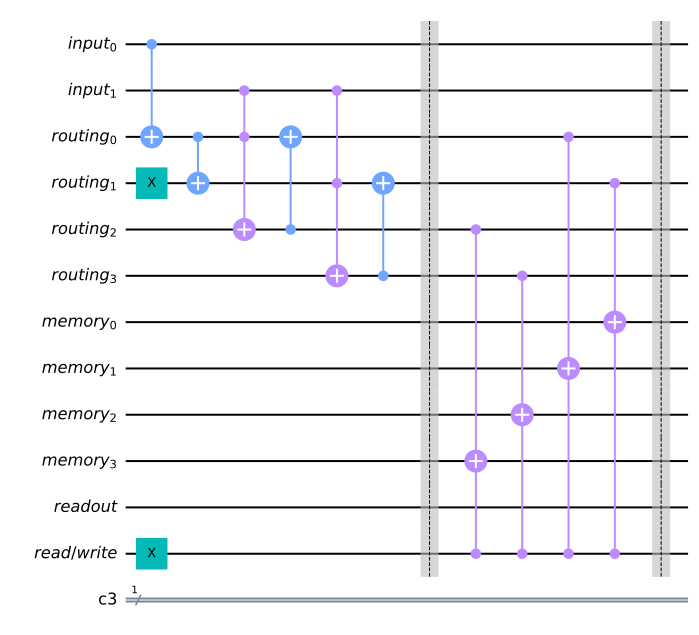

In [9]:
inp = QuantumRegister(2,'input')
r = QuantumRegister(4,'routing')
mem = QuantumRegister(4,'memory')
rdwr = QuantumRegister(1,'read/write')
ro = QuantumRegister(1,'readout')
cr = ClassicalRegister(1)
qcw = QuantumCircuit(inp,r,mem,ro,rdwr,cr)
#qcw.x(inp[0])
#qc.i(mem[1:4])
'''
qc.cswap(inp[0],mem[0],mem[2])
qc.cswap(inp[1],mem[0],mem[1])
qc.cswap(inp[1],mem[2],mem[3])
'''
qcw.x(rdwr[0])
### Routing nodes ####

qcw.cx(inp[0],r[0])
qcw.x(r[1])
qcw.cx(r[0],r[1])

qcw.ccx(inp[1],r[0],r[2])
qcw.cx(r[2],r[0])

qcw.ccx(inp[1],r[1],r[3])
qcw.cx(r[3],r[1])

qcw.barrier()

### Write State ###
qcw.ccx(rdwr[0],r[2],mem[3])
qcw.ccx(rdwr[0],r[3],mem[2])
qcw.ccx(rdwr[0],r[0],mem[1])
qcw.ccx(rdwr[0],r[1],mem[0])
qcw.barrier()
#qcw.measure(ro,cr)

qcw.draw('mpl')

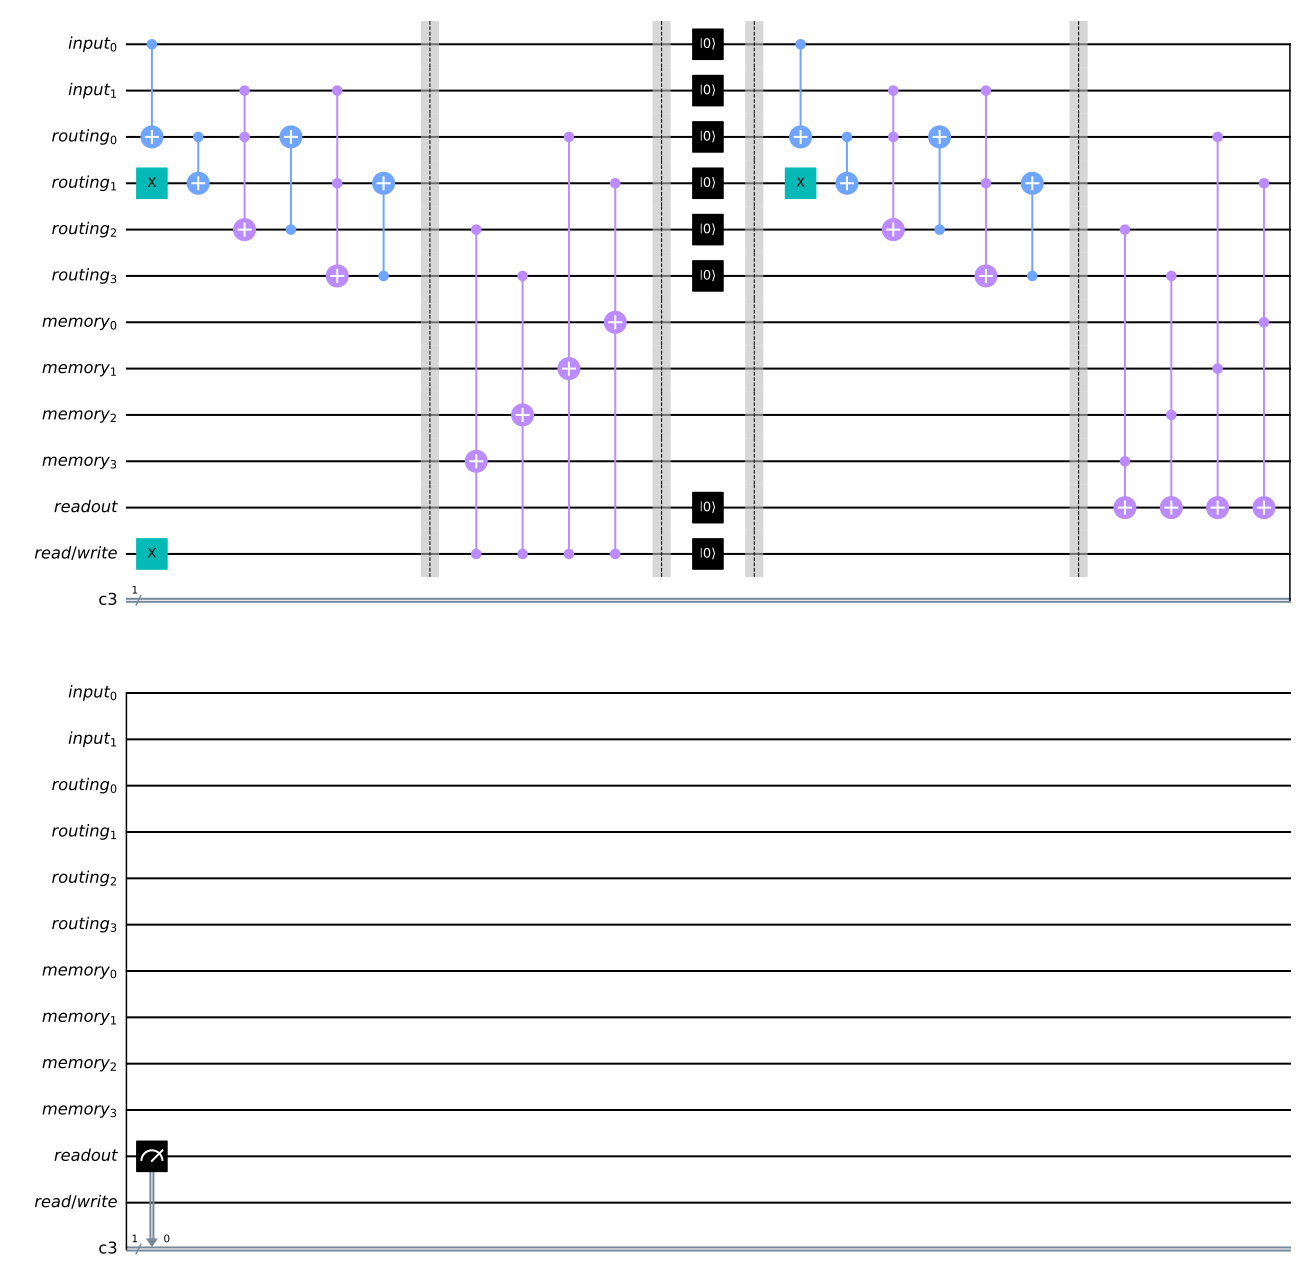

In [10]:
res = QuantumCircuit(inp,r,mem,ro,rdwr,cr)
res.reset(inp)
res.reset(rdwr)
res.reset(r)
res.reset(ro)
res.barrier()
res.draw()
qc  = qcw.compose(res)
qc = qc.compose(qcr)
qc.draw('mpl')

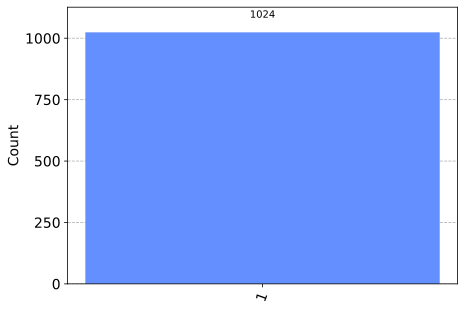

In [12]:
# Output 
sim = Aer.get_backend('aer_simulator') 
result = sim.run(qc).result()
counts = result.get_counts()
plot_histogram(counts)

## Read Operation Optimization

In [43]:
c = zx.Circuit.load("QASM_Files_QRAM/readopn.qasm")
c = c.to_basic_gates()
print(c.stats())

Circuit readopn.qasm on 12 qubits with 95 gates.
        42 is the T-count
        53 Cliffords among which
        40 2-qubit gates (40 CNOT, 0 other) and
        12 Hadamard gates.


In [44]:
g = c.to_graph()
roriginal = zx.draw_matplotlib(g).savefig('orzx.png')

In [45]:
zx.simplify.full_reduce(g) 
zx.draw_matplotlib(g).savefig('reduction.png')
c2 = zx.extract_circuit(g).to_basic_gates() 
zx.draw_matplotlib(c2).savefig('opzx.png')# Turn graph back into circuit
print(c2.stats())

Circuit  on 12 qubits with 209 gates.
        36 is the T-count
        173 Cliffords among which
        94 2-qubit gates (31 CNOT, 63 other) and
        76 Hadamard gates.


In [10]:
#print(c2.to_qasm())

In [11]:
opr = QuantumCircuit.from_qasm_file('opread.qasm')
ogr = opr.to_gate()


## Write Operation Optimization

In [12]:
c = zx.Circuit.load("QASM_Files_QRAM/writeopn.qasm")
c = c.to_basic_gates()
print(c.stats())

Circuit writeopn.qasm on 12 qubits with 96 gates.
        42 is the T-count
        54 Cliffords among which
        40 2-qubit gates (40 CNOT, 0 other) and
        12 Hadamard gates.


In [13]:
g = c.to_graph()


In [14]:
zx.simplify.full_reduce(g) 
zx.draw(g)
c2 = zx.extract_circuit(g).to_basic_gates() 
zx.draw(c2)# Turn graph back into circuit
print(c2.stats())

Circuit  on 12 qubits with 253 gates.
        36 is the T-count
        217 Cliffords among which
        126 2-qubit gates (32 CNOT, 94 other) and
        88 Hadamard gates.


In [15]:
#print(c2.to_qasm())

# CSWAP modification to QRAM Architecture

## Read Operation

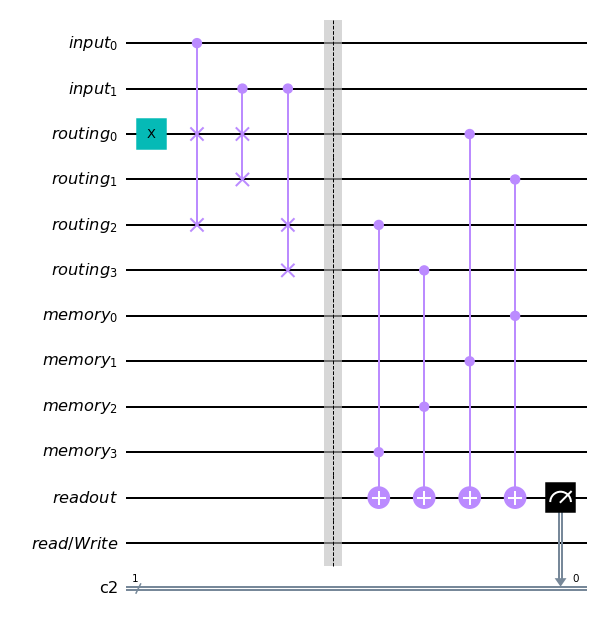

In [16]:
inp = QuantumRegister(2,'input')
r = QuantumRegister(4,'routing')
mem = QuantumRegister(4,'memory')
rdwr = QuantumRegister(1,'read/Write')
ro = QuantumRegister(1,'readout')
cr = ClassicalRegister(1)
qcr = QuantumCircuit(inp,r,mem,ro,rdwr,cr)
#qcr.x(inp[0])
#qcr.x(inp[1])


### Routing nodes ####
qcr.x(r[0])
qcr.cswap(inp[0],r[0],r[2])
qcr.cswap(inp[1],r[0],r[1])
qcr.cswap(inp[1],r[2],r[3])


qcr.barrier()

### Read State ###
qcr.ccx(r[2],mem[3],ro[0])
qcr.ccx(r[3],mem[2],ro[0])
qcr.ccx(r[0],mem[1],ro[0])
qcr.ccx(r[1],mem[0],ro[0])
qcr.measure(ro,cr)
qcr.draw('mpl')

# Write Operation

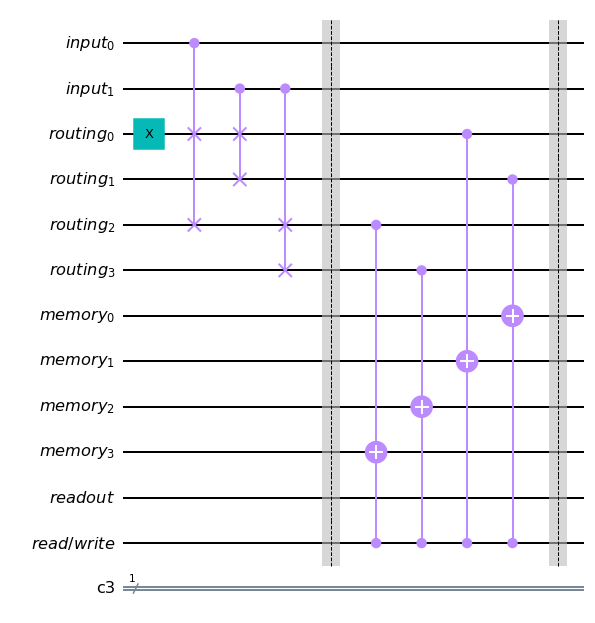

In [17]:
inp = QuantumRegister(2,'input')
r = QuantumRegister(4,'routing')
mem = QuantumRegister(4,'memory')
rdwr = QuantumRegister(1,'read/write')
ro = QuantumRegister(1,'readout')
cr = ClassicalRegister(1)
qcw = QuantumCircuit(inp,r,mem,ro,rdwr,cr)
#qcw.x(inp[0])
#qcw.x(inp[1])

### Routing nodes ####
qcw.x(r[0])
qcw.cswap(inp[0],r[0],r[2])
qcw.cswap(inp[1],r[0],r[1])
qcw.cswap(inp[1],r[2],r[3])

qcw.barrier()

### Write State ###
qcw.ccx(rdwr[0],r[2],mem[3])
qcw.ccx(rdwr[0],r[3],mem[2])
qcw.ccx(rdwr[0],r[0],mem[1])
qcw.ccx(rdwr[0],r[1],mem[0])
qcw.barrier()
#qcw.measure(ro,cr)

qcw.draw(output='mpl')

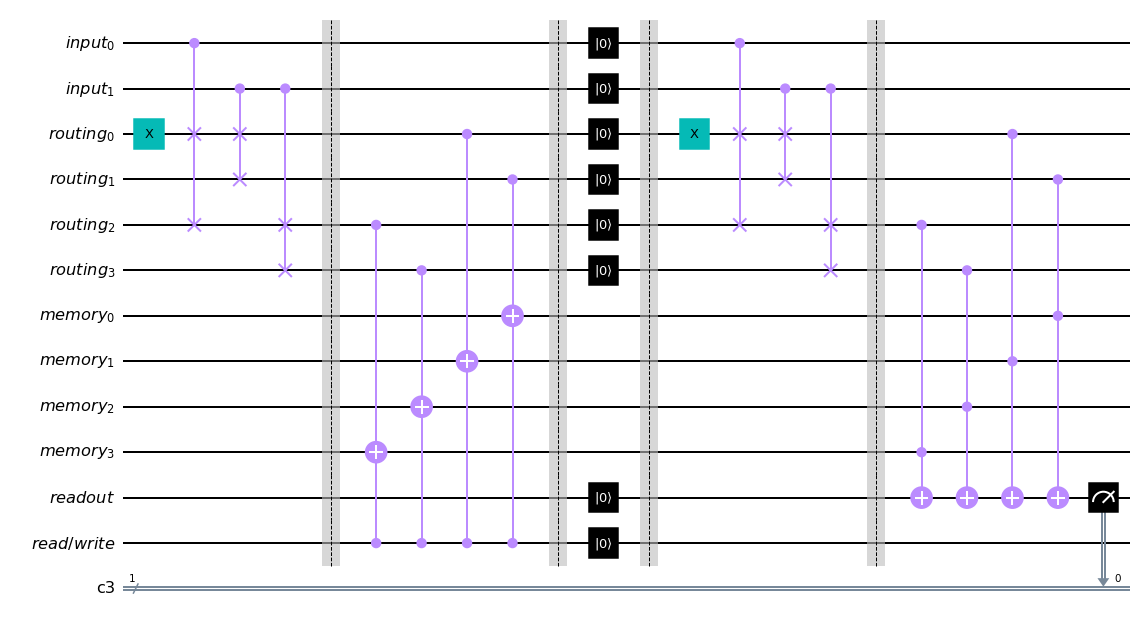

In [18]:
res = QuantumCircuit(inp,r,mem,ro,rdwr,cr)
res.reset(inp)
res.reset(rdwr)
res.reset(r)
res.reset(ro)
res.barrier()
res.draw()
qc  = qcw.compose(res)
qc = qc.compose(qcr)
qc.draw('mpl')

## Read Operation Optimization

In [19]:
c = zx.Circuit.load("QASM_Files_QRAM/rdopnf.qasm")
c = c.to_basic_gates()
print(c.stats())

Circuit rdopnf.qasm on 12 qubits with 196 gates.
        91 is the T-count
        105 Cliffords among which
        78 2-qubit gates (78 CNOT, 0 other) and
        26 Hadamard gates.


In [20]:
g = c.to_graph()
zx.draw(g)

In [21]:
zx.simplify.full_reduce(g) 
zx.draw(g)
c2 = zx.extract_circuit(g).to_basic_gates() 
zx.draw(c2)# Turn graph back into circuit
print(c2.stats())

Circuit  on 12 qubits with 385 gates.
        73 is the T-count
        312 Cliffords among which
        168 2-qubit gates (57 CNOT, 111 other) and
        140 Hadamard gates.


In [22]:
#print(c2.to_qasm())

## Write Operation Optimization

In [23]:
c = zx.Circuit.load("QASM_Files_QRAM/wropnf.qasm")
c = c.to_basic_gates()
print(c.stats())

Circuit wropnf.qasm on 12 qubits with 196 gates.
        91 is the T-count
        105 Cliffords among which
        78 2-qubit gates (78 CNOT, 0 other) and
        26 Hadamard gates.


In [24]:
g = c.to_graph()
zx.draw(g)

In [25]:
zx.simplify.full_reduce(g) 
zx.draw(g)
c2 = zx.extract_circuit(g).to_basic_gates() 
zx.draw(c2)# Turn graph back into circuit
print(c2.stats())

Circuit  on 12 qubits with 377 gates.
        73 is the T-count
        304 Cliffords among which
        156 2-qubit gates (42 CNOT, 114 other) and
        144 Hadamard gates.


In [26]:
#print(c2.to_qasm())

# Dynamic Circuit Approach

### Read Operation Optimization

In [27]:
c = zx.Circuit.load("QASM_Files_QRAM/rdopnd.qasm")
c = c.to_basic_gates()
print(c.stats())

Circuit rdopnd.qasm on 12 qubits with 50 gates.
        21 is the T-count
        29 Cliffords among which
        22 2-qubit gates (22 CNOT, 0 other) and
        6 Hadamard gates.


In [28]:
g = c.to_graph()
zx.draw(g)

In [29]:
zx.simplify.full_reduce(g) 
zx.draw(g)
c2 = zx.extract_circuit(g).to_basic_gates() 
zx.draw(c2)# Turn graph back into circuit
print(c2.stats())

Circuit  on 12 qubits with 109 gates.
        19 is the T-count
        90 Cliffords among which
        44 2-qubit gates (19 CNOT, 25 other) and
        44 Hadamard gates.


In [30]:
#print(c2.to_qasm())

### Write Operation Optimization

In [31]:
c = zx.Circuit.load("QASM_Files_QRAM/wropnd.qasm")
c = c.to_basic_gates()
print(c.stats())

Circuit wropnd.qasm on 12 qubits with 51 gates.
        21 is the T-count
        30 Cliffords among which
        22 2-qubit gates (22 CNOT, 0 other) and
        6 Hadamard gates.


In [32]:
g = c.to_graph()
zx.draw(g)

In [33]:
zx.simplify.full_reduce(g) 
zx.draw(g)
c2 = zx.extract_circuit(g).to_basic_gates() 
zx.draw(c2)# Turn graph back into circuit
print(c2.stats())

Circuit  on 12 qubits with 118 gates.
        19 is the T-count
        99 Cliffords among which
        48 2-qubit gates (15 CNOT, 33 other) and
        48 Hadamard gates.


In [34]:
#print(c2.to_qasm())